In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import random
import time

In [2]:
# Load the saved VGG16 model (feature extractor)
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('flatten').output)

# Freeze VGG16 layers
for layer in vgg16_model.layers:
    layer.trainable = False

In [3]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

# Image preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, vgg16_model)
test_features, test_labels = extract_features(test_generator, vgg16_model)

print(f"Original feature dimensions: {train_features.shape[1]}")

54/54 [==============================] - 415s 8s/step
Original feature dimensions: 25088


In [6]:
# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [7]:
def jaya_optimization(train_features, train_labels, test_features, test_labels, max_iter=10, population_size=5):
    """
    Jaya Optimization for PCA components and Random Forest hyperparameters.
    """
    start_time = time.time()  # Start timer

    # Define hyperparameter ranges
    min_components, max_components = 100, 400
    min_n_estimators, max_n_estimators = 50, 500
    min_max_depth, max_max_depth = 5, 50

    # Initialize population
    population = []
    for _ in range(population_size):
        params = {
            'n_components': random.randint(min_components, max_components),
            'n_estimators': random.randint(min_n_estimators, max_n_estimators),
            'max_depth': random.randint(min_max_depth, max_max_depth),
        }
        population.append(params)

    # Evaluate initial population
    def evaluate(params):
        pca = PCA(n_components=params['n_components'])
        train_pca = pca.fit_transform(train_features)
        test_pca = pca.transform(test_features)

        rf = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=42)
        rf.fit(train_pca, train_labels)
        predictions = rf.predict(test_pca)
        return accuracy_score(test_labels, predictions)

    best_params = None
    best_accuracy = 0

    for iteration in range(max_iter):
        new_population = []

        for params in population:
            # Generate new candidates
            new_params = {
                'n_components': random.randint(min_components, max_components),
                'n_estimators': random.randint(min_n_estimators, max_n_estimators),
                'max_depth': random.randint(min_max_depth, max_max_depth),
            }

            # Evaluate both old and new candidates
            old_acc = evaluate(params)
            new_acc = evaluate(new_params)

            # Select the better one
            if new_acc > old_acc:
                new_population.append(new_params)
            else:
                new_population.append(params)

            # Update the best accuracy
            if new_acc > best_accuracy:
                best_accuracy = new_acc
                best_params = new_params

        population = new_population
        print(f"Iteration {iteration + 1}/{max_iter}, Best Accuracy: {best_accuracy:.4f}")

    end_time = time.time()  # End timer
    print(f"Jaya Optimization Time: {end_time - start_time:.2f} seconds")  # Print execution time

    return best_params

In [8]:
# Run Jaya Optimization
best_params = jaya_optimization(train_features_scaled, train_labels, test_features_scaled, test_labels)


Iteration 1/10, Best Accuracy: 0.7210
Iteration 2/10, Best Accuracy: 0.7523
Iteration 3/10, Best Accuracy: 0.7523
Iteration 4/10, Best Accuracy: 0.7523
Iteration 5/10, Best Accuracy: 0.7523
Iteration 6/10, Best Accuracy: 0.7523
Iteration 7/10, Best Accuracy: 0.7523
Iteration 8/10, Best Accuracy: 0.7523
Iteration 9/10, Best Accuracy: 0.7523
Iteration 10/10, Best Accuracy: 0.7535
Jaya Optimization Time: 3681.69 seconds


In [9]:
# Apply best PCA
pca = PCA(n_components=best_params['n_components'])
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print(f"Optimized PCA components: {best_params['n_components']}")
print(f"Feature count before PCA: {train_features.shape[1]}")
print(f"Feature count after PCA: {train_features_pca.shape[1]}")

Optimized PCA components: 135
Feature count before PCA: 25088
Feature count after PCA: 135


In [10]:
# Train optimized RF
rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
rf_classifier.fit(train_features_pca, train_labels)

RandomForestClassifier(max_depth=30, n_estimators=179, random_state=42)

In [11]:
# Predict and evaluate
test_predictions = rf_classifier.predict(test_features_pca)
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Optimized Test Accuracy: {accuracy:.4f}")

Optimized Test Accuracy: 0.7506


In [12]:
from sklearn.metrics import classification_report
import cv2
import os

# Generate Classification Report
report = classification_report(test_labels, test_predictions, target_names=['Benign', 'Malignant'])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Benign       0.88      0.24      0.38       542
   Malignant       0.74      0.98      0.84      1182

    accuracy                           0.75      1724
   macro avg       0.81      0.61      0.61      1724
weighted avg       0.78      0.75      0.70      1724



In [13]:
# Save models
joblib.dump(rf_classifier, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\rf_optimized.pkl")
joblib.dump(pca, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\pca_optimized.pkl")
joblib.dump(scaler, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\scaler.pkl")

print("Optimized RF, PCA, and Scaler models saved successfully!")

Optimized RF, PCA, and Scaler models saved successfully!


In [17]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model

# Load the saved VGG16 model
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")

# Extract features from the correct layer (use 'fc1' or 'flatten')
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer("flatten").output)

# Load pre-trained scaler, PCA, and RF model
scaler = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\scaler.pkl")
pca = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\pca_optimized.pkl")
rf_classifier = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\rf_optimized.pkl")

# Class labels
class_labels = ["Benign", "Malignant"]


1/1 [==============================] - 0s 280ms/step


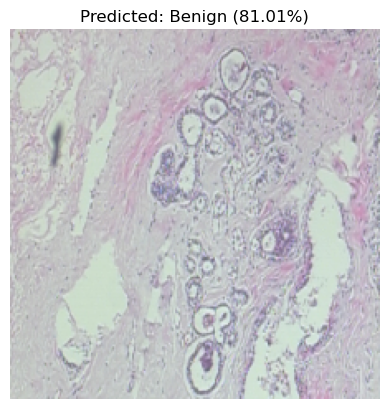

Confidence Scores:
  Benign: 81.01%
  Malignant: 18.99%


In [19]:
def predict_single_image_rf(image_path):
    """
    Predicts a single image using Random Forest after feature extraction with VGG16.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using the correct layer
    extracted_features = feature_extractor.predict(img_array)

    # Standardize features
    extracted_features_scaled = scaler.transform(extracted_features)

    # Apply PCA for dimensionality reduction
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Get prediction from RF classifier
    prediction_probs = rf_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class = np.argmax(prediction_probs)

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[predicted_class]} ({prediction_probs[predicted_class] * 100:.2f}%)")
    plt.show()

    # Print class probabilities
    print(f"Confidence Scores:")
    for i, label in enumerate(class_labels):
        print(f"  {label}: {prediction_probs[i] * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png"
predict_single_image_rf(image_path)


1/1 [==============================] - 0s 285ms/step


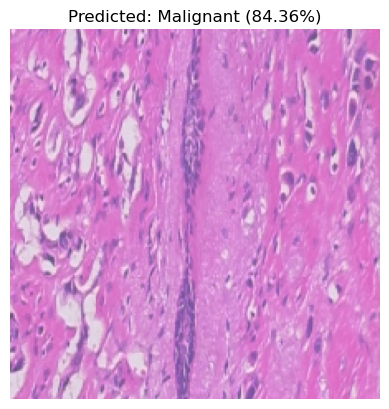

Confidence Scores:
  Benign: 15.64%
  Malignant: 84.36%


In [20]:
def predict_single_image_rf(image_path):
    """
    Predicts a single image using Random Forest after feature extraction with VGG16.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using the correct layer
    extracted_features = feature_extractor.predict(img_array)

    # Standardize features
    extracted_features_scaled = scaler.transform(extracted_features)

    # Apply PCA for dimensionality reduction
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Get prediction from RF classifier
    prediction_probs = rf_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class = np.argmax(prediction_probs)

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[predicted_class]} ({prediction_probs[predicted_class] * 100:.2f}%)")
    plt.show()

    # Print class probabilities
    print(f"Confidence Scores:")
    for i, label in enumerate(class_labels):
        print(f"  {label}: {prediction_probs[i] * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\lobular_carcinoma\SOB_M_LC_14-15570\100X\SOB_M_LC-14-15570-100-046.png"
predict_single_image_rf(image_path)
